<a href="https://colab.research.google.com/github/lehani1/Stock-Market-Prediction-LSTM/blob/main/Stock_market_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from io import BytesIO
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## Data Fetching API



In [2]:
class NSE():
    def __init__(self, timeout=10):
        self.base_url = 'https://www.nseindia.com'
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1823.43",
            "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
            "accept-language": "en-US,en;q=0.9"
        }
        self.timeout = timeout
        self.cookies = []

    def __getCookies(self, renew=False):
        if len(self.cookies) > 0 and renew == False:
            return self.cookies

        r = requests.get(self.base_url, timeout=self.timeout, headers=self.headers)
        self.cookies = dict(r.cookies)
        return self.__getCookies()

    def getHistoricalData(self, symbol, series, from_date, to_date):
        try:
            url = "/api/historical/cm/equity?symbol={0}&series=[%22{1}%22]&from={2}&to={3}&csv=true".format(symbol.replace('&', '%26'), series, from_date.strftime('%d-%m-%Y'), to_date.strftime('%d-%m-%Y'))
            r = requests.get(self.base_url + url, headers=self.headers, timeout=self.timeout, cookies=self.__getCookies())
            if r.status_code != 200:
                r = requests.get(self.base_url + url, headers=self.headers, timeout=self.timeout, cookies=self.__getCookies(True))

            df = pd.read_csv(BytesIO(r.content), sep=',', thousands=',')
            df = df.rename(columns={ 'Date ': 'date','series ': 'series', 'OPEN ': 'open', 'HIGH ': 'high', 'LOW ': 'low', 'PREV. CLOSE ': 'prev_close', 'ltp ': 'ltp', 'close ': 'close', '52W H ': 'hi_52_wk', '52W L ': 'lo_52_wk', 'VOLUME ': 'trdqty', 'VALUE ': 'trdval', 'No of trades ': 'trades'})
            df.date = pd.to_datetime(df.date)
            df.set_index("date", inplace = True)
            df.sort_index(inplace = True)
            return df
        except:
            return None



## Collecting the Data


In [76]:
# Stock company CODE

stock = "SBIN"

In [77]:
nse = NSE()
## Date fromat : yyyy,mm,dd

df = nse.getHistoricalData(stock, 'EQ', date(2022,7,4), date(2023,7,3))

In [78]:
df

,series,open,high,low,prev_close,ltp,close,vwap,hi_52_wk,lo_52_wk,trdqty,trdval,trades
date,,,,,,,,,,,,,
2022-07-04,EQ,466.85,474.15,466.85,466.85,473.95,473.45,470.57,549.00,401.25,9186358,4.322794e+09,115285
2022-07-05,EQ,475.15,480.00,471.00,473.45,472.55,472.15,475.99,549.00,401.25,12003244,5.713385e+09,143727
2022-07-06,EQ,475.15,481.00,473.90,472.15,480.55,479.95,478.18,549.00,401.25,12059857,5.766833e+09,179395
2022-07-07,EQ,484.00,488.25,481.60,479.95,486.90,486.75,485.27,549.00,401.25,11497832,5.579594e+09,173806
2022-07-08,EQ,489.00,489.90,485.15,486.75,488.45,488.55,487.44,549.00,401.25,9057231,4.414856e+09,162363
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,EQ,556.00,558.50,554.50,554.60,557.35,557.05,556.75,629.55,458.00,8360264,4.654618e+09,164198
2023-06-27,EQ,558.25,567.95,555.65,557.05,567.30,566.10,560.63,629.55,458.00,10694768,5.995786e+09,211284
2023-06-28,EQ,572.25,574.00,568.55,566.10,571.00,569.80,571.17,629.55,458.00,18028934,1.029766e+10,243601


## Pre Processing


In [44]:
cols = [
    "open",
    "high",
    "low",
    "close",
    "trdqty"
]

In [45]:
df = df[cols]

In [46]:
df

,open,high,low,close,trdqty
date,,,,,
2022-07-04,466.85,474.15,466.85,473.45,9186358
2022-07-05,475.15,480.00,471.00,472.15,12003244
2022-07-06,475.15,481.00,473.90,479.95,12059857
2022-07-07,484.00,488.25,481.60,486.75,11497832
2022-07-08,489.00,489.90,485.15,488.55,9057231
...,...,...,...,...,...
2023-06-26,556.00,558.50,554.50,557.05,8360264
2023-06-27,558.25,567.95,555.65,566.10,10694768
2023-06-28,572.25,574.00,568.55,569.80,18028934


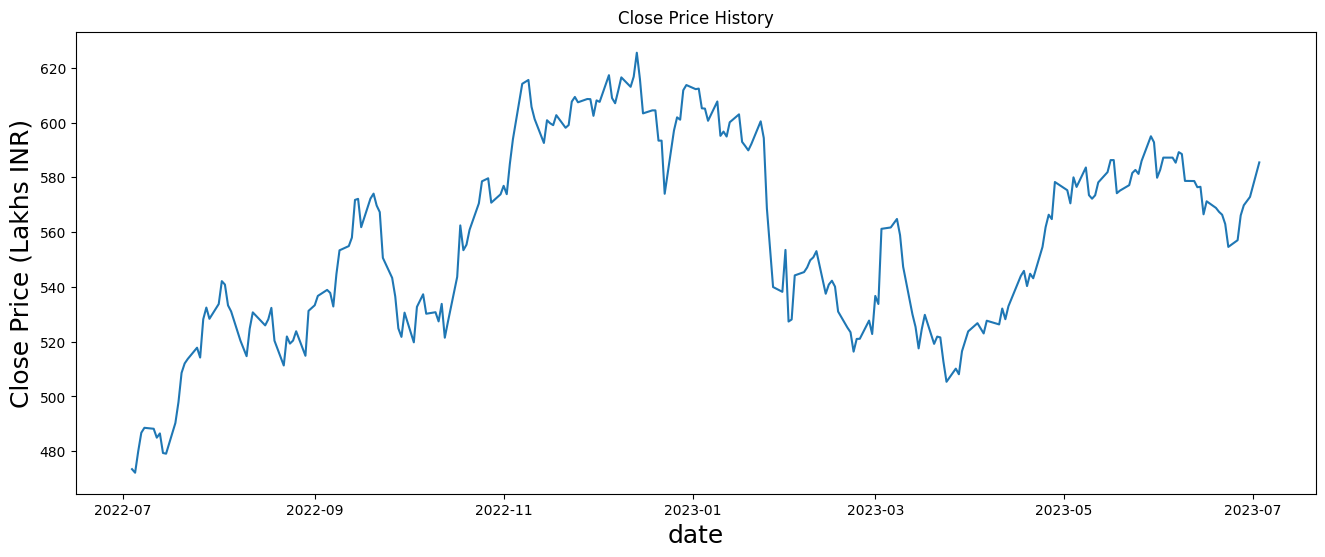

In [47]:
plt.figure(figsize=(16,6))
plt.title("Close Price History")
plt.plot(df["close"])
plt.xlabel("date", fontsize=18)
plt.ylabel("Close Price (Lakhs INR)", fontsize = 18)
plt.show()

In [48]:
data = df.filter(["close"])
dataset = data.values
train_data_len = int(np.ceil(len(dataset)*0.8))
train_data_len

198

In [61]:
type(dataset)

numpy.ndarray

In [ ]:
u = np.mean(dataset)
sigma = np.std(dataset)

std_data = (dataset - u)/sigma
std_data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

In [72]:

train_data = scaled_data[0:int(train_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00847734, 0.        , 0.05086404, 0.09520704, 0.1069449 ,
       0.10466254, 0.08346919, 0.09357679, 0.04695142, 0.04532116,
       0.1183567 , 0.16824258, 0.23769156, 0.26018911, 0.27094881,
       0.29768503, 0.27420933, 0.36550375, 0.39321813, 0.3664819 ,
       0.40169547, 0.45614607, 0.44799478, 0.39843495, 0.38408869,
       0.31463971, 0.27746984, 0.34300619, 0.38180633, 0.35083143,
       0.3651777 , 0.39256603, 0.31431366, 0.25529834, 0.32442126,
       0.30746658, 0.31463971, 0.33681122, 0.27844799, 0.38539289,
       0.398761  , 0.42093251, 0.43527877, 0.42810564, 0.39582654,
       0.4727747 , 0.52950766, 0.53961526, 0.55983045, 0.64949462,
       0.65210303, 0.58461037, 0.65275514, 0.66449299, 0.63612651,
       0.62047604, 0.51157483, 0.46397131, 0.4196283 , 0.3436583 ])]
[0.32344310401043375]

[array([0.00847734, 0.        , 0.05086404, 0.09520704, 0.1069449 ,
       0.10466254, 0.08346919, 0.09357679, 0.04695142, 0.04532116,
       0.1183567 , 0.16824258, 0.23

## Training Part

In [73]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
138/138 [==============================] - 12s 52ms/step - loss: 0.0278
Epoch 2/5
138/138 [==============================] - 6s 44ms/step - loss: 0.0145
Epoch 3/5
138/138 [==============================] - 7s 47ms/step - loss: 0.0121
Epoch 4/5
138/138 [==============================] - 5s 38ms/step - loss: 0.0099
Epoch 5/5
138/138 [==============================] - 6s 44ms/step - loss: 0.0083


## Testing Part

In [74]:
test_data = scaled_data[train_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 32ms/step


10.235563638816783

<ipython-input-75-e56069d57ba4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


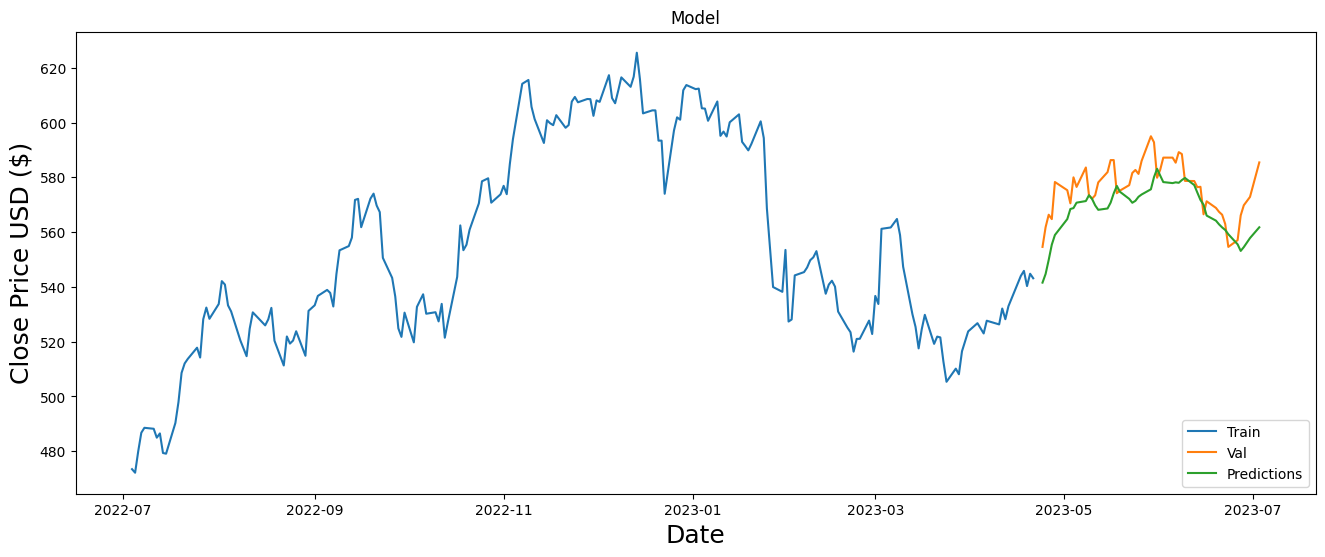

In [75]:
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [ ]:
valid

In [79]:
model.save(f"{stock}.h5")